# Zach Holcomb
#### Fake News Detection Model

In [ ]:
import pandas as pd
import os
from kaggle.api.kaggle_api_extended import KaggleApi # This line doesn't work on first try, works fine after that
import numpy as np

In [ ]:
# ChatGPT used during this project: https://chatgpt.com/share/675b6694-894c-800e-8dd0-32cd56f5370c
# Initialize the Kaggle API
api = KaggleApi()
# api.authenticate()

# Download the dataset
dataset = "clmentbisaillon/fake-and-real-news-dataset"
api.dataset_download_files(dataset, path=".", unzip=True)

# Load the dataset into a DataFrame
fake = pd.read_csv("./Fake.csv")
true = pd.read_csv("./True.csv")

# Print the DataFrame's head to confirm successful loading
fake.head(10)
true.head(10)

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [ ]:
true['type'] = True
fake['type'] = False

In [ ]:
data = pd.concat([true, fake], axis=0)
data = data.drop(['title', 'subject', 'date'], axis='columns')
data = data.drop_duplicates()

data['text'] = data['text'].str.lower()
data['text'] = data['text'].where(
    ~data['text'].str.contains('-', na=False),  # Keep strings without a hyphen
    data['text'].str.split('-', n=1).str[1].str.strip()  # Clean strings with a hyphen
)
data['text'] = data['text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

data.head(20)

,text,type
0,the head of a conservative republican faction ...,True
1,transgender people will be allowed for the fir...,True
2,the special counsel investigation of links bet...,True
3,trump campaign adviser george papadopoulos tol...,True
4,president donald trump called on the us postal...,True
5,the white house said on friday it was set to k...,True
6,president donald trump said on thursday he bel...,True
7,while the fake news loves to talk about my soc...,True
8,together we are making america great again bit...,True
9,alabama secretary of state john merrill said h...,True


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

texts = data['text'].tolist()
labels = data['type'].tolist()

# Assuming `texts` contains article texts and `labels` contains the target column
max_words = 10000  # Size of the vocabulary
max_len = 100      # Maximum sequence length

# Tokenize and convert to sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)  # Assuming labels are already binary (0 or 1)

# Custom weighted loss function to prioritize fake news accuracy
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

# Create a dictionary for the weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}  # Fake = 0, True = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer='rmsprop', loss='hinge', metrics=['accuracy', 'recall', 'precision'])
model.summary()

# Train the model
# history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8340 - loss: 0.7130 - precision: 0.8682 - recall: 0.8096 - val_accuracy: 0.9636 - val_loss: 0.4896 - val_precision: 0.9637 - val_recall: 0.9703
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9656 - loss: 0.5282 - precision: 0.9640 - recall: 0.9744 - val_accuracy: 0.9664 - val_loss: 0.4852 - val_precision: 0.9552 - val_recall: 0.9849
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9707 - loss: 0.5326 - precision: 0.9673 - recall: 0.9795 - val_accuracy: 0.9636 - val_loss: 0.4872 - val_precision: 0.9535 - val_recall: 0.9816
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9739 - loss: 0.5347 - precision: 0.9754 - recall: 0.9762 - val_accuracy: 0.9682 - val_loss: 0.4832 - val_precision: 0.9568 - val_recall: 0.9866
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9739 - loss: 0.5280 - precision: 0.9763 - recall: 0.9759 - val_accuracy: 0.9467 - val_loss

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.4779 - precision: 0.9718 - recall: 0.9829
Test Accuracy: 97.49%
Test Recall: 98.21%
Test Precision: 97.25%


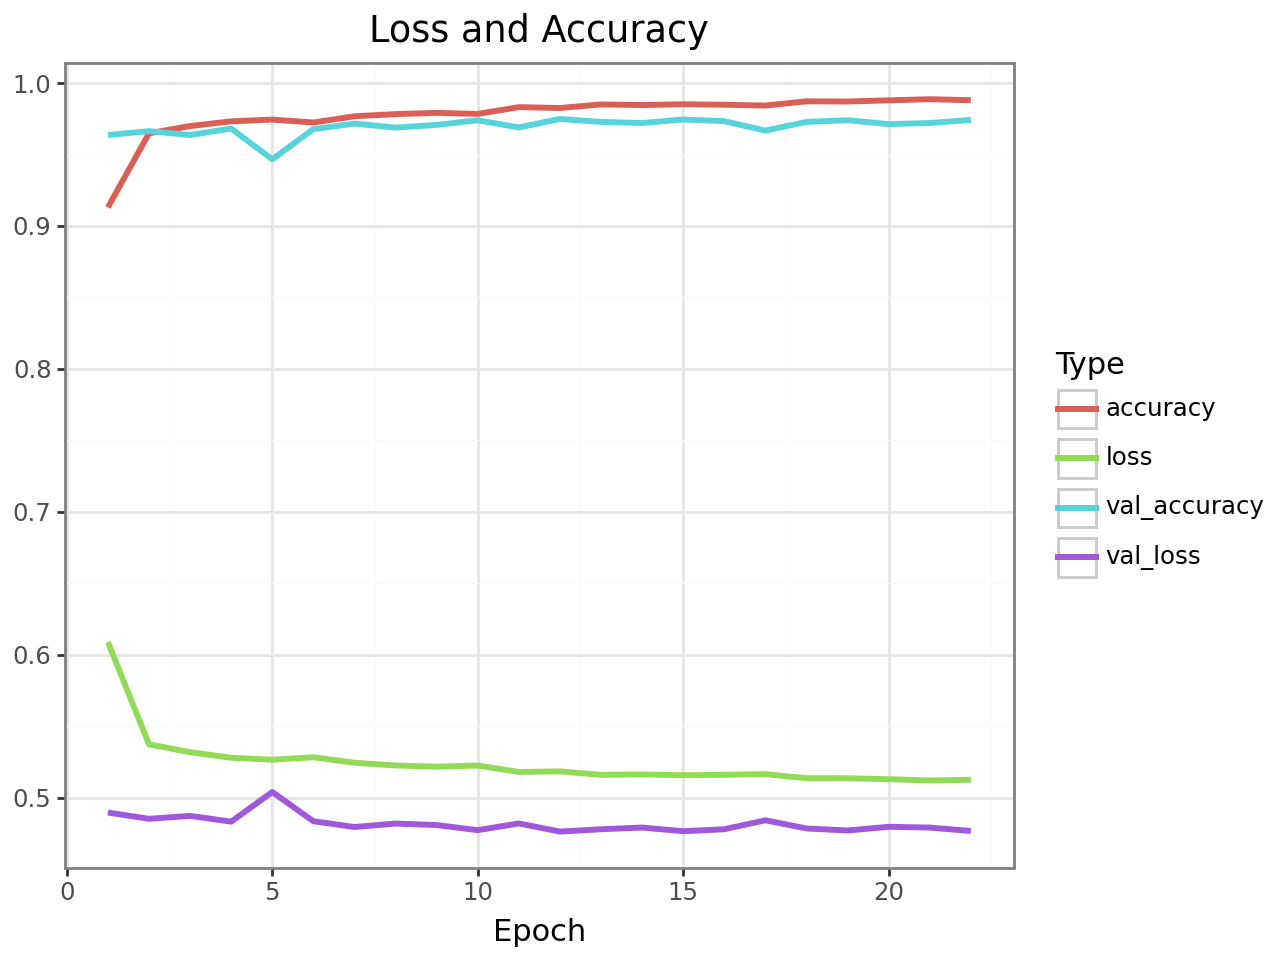

In [ ]:
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%\nTest Recall: {recall*100:.2f}%\nTest Precision: {precision*100:.2f}%")

from plotnine import ggplot, aes, geom_line, labs, theme_bw, ylim

history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})

history_df = history_df.melt(id_vars=['epoch'], var_name='Metric', value_name='Value')

loss_plot = (
    ggplot(history_df, aes(x='epoch', y='Value', color='Metric')) +
    geom_line(size=1.2) +
    labs(
        title="Loss and Accuracy",
        x="Epoch",
        y="",
        color="Type"
    ) +
    # ylim(0, 0.7) +
    theme_bw()
)

loss_plot

In [ ]:
from sklearn.metrics import accuracy_score
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get accuracy for True (1) and Fake (0) separately
true_accuracy = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
fake_accuracy = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])

print(f"Accuracy for True articles: {true_accuracy * 100:.2f}%")
print(f"Accuracy for Fake articles: {fake_accuracy * 100:.2f}%")

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy for True articles: 98.21%
Accuracy for Fake articles: 96.62%


In [ ]:
import re
import numpy as np  # Import numpy

def clean_article(text):
    text=text.lower()
    # if '-' in text:
    #   text = text.split('-', 1)[1]
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text) # Use re.sub for regex replacement
    return text

# https://abcnews.go.com/US/unitedhealthcare-ceo-killing-latest-mangiones-veteran-new-york/story?id=116787673
text = 'UnitedHealthcare CEO killing latest: Investigators spoke to Mangione\'s mother before arrest. Mangione’s mother had filed a missing persons report about her son on Nov. 18."'

# Convert the list of lists to a NumPy array and pad it
sequences = tokenizer.texts_to_sequences([clean_article(text)])
padded_sequences = pad_sequences(sequences, maxlen=100) # Pad to match training data shape

result = model.predict(padded_sequences) # Pass the padded NumPy array
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
[[0.9994198]]
